---
layout: post
title:  "Principal Component Analysis - PCA"
date:   2022-02-08 08:14:54 +0700
categories: MachineLearning
---

# Introduction

Principle component analysis (PCA) is to analyze the main components of input data. Usually this means to find the main dimensions of the input so that when we do projection of data points onto those dimensions, we don't lose much of the information. The information preserved is measured by the amount of variance preserved - an indirect indicator. The first step in PCA is to substract the input for the mean of it, this is done automatically in sklearn. Then we choose the number of dimensions that retain at least 90-95%. How? Imagine all the data points are on the axis, now we rebase the origin to be zero. Then the principal dimensions of the data are the eigenvectors of the covariance matrix. With the top eigen vector to be the most importance component (direction). Let $$ \lambda_1, \lambda_2,..\lambda_n $$ to be the eigen values accordingly (sorted in decreasing order). If we retain k principal components, the percentage of variance retained is: $$ \frac{\sum_{j=1}^{k}\lambda_j}{\sum_{j=1}^{n}\lambda_j} $$. Hence we can calculate how many dimensions to retain how much variance. When we recover the images from after PCA, we have a noisy images and PCA can be seen as a compression scheme. PCA can be done for any high dimensional data set.


# Code example

Let's consider the face dataset from Yale. To retain 95% of the variance, we keep 68 principle dimensions. When we run random forest on X, the accuracy is 42%, which is low, due to the small number of images. We plot the feature importance and it focus on eyes, noses and chin. After PCA, the accuracy reduces to 33% (we loses 10% of prediction). We can say that, small details on the faces are accounted for about 1/4 of the prediction ability. When we restore the images, and run the random forest again, the accuracy rises back to 39%. When we plot feature importance, the heatmap shows that after PCA, the algorithm only glances at the picture, with a comprehension on light and the complexion. 

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns
import pandas as pd
import numpy as np
import os

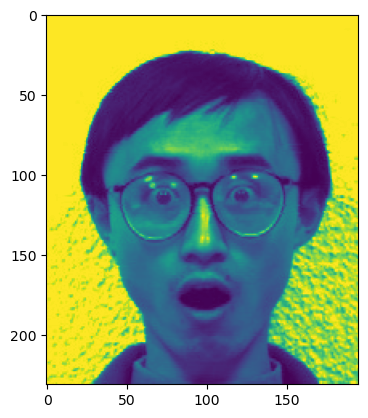

(231, 195)
(165, 45045)


glasses        15
noglasses      15
centerlight    15
happy          15
leftlight      15
normal         15
rightlight     15
sleepy         15
wink           15
sad            15
surprised      15
dtype: int64

In [2]:
PATH='./yalefaces/'
image_paths=next(os.walk(PATH))[2]
X =[]
y=[]
for i in range(165):
    image_name=image_paths[i]
    image = plt.imread(PATH+image_name)
    X.append(image.flatten())
    y.append(image_name[10:-5])
plt.imshow(image)
plt.show()
print(image.shape)
X=np.array(X)
print(X.shape)
pd.Series(y).value_counts()

![9PCA_2_0](https://user-images.githubusercontent.com/7457301/224486223-d9fbf7b6-90ae-4751-a2fa-87e2dfcd1e39.png)

Accuracy: 42.42%


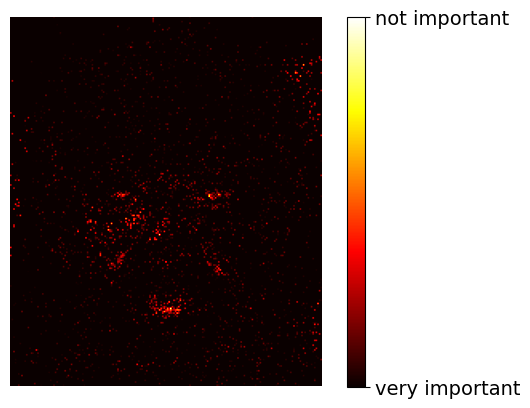

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

heatmap_image = rnd_clf.feature_importances_.reshape(231,195)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['very important', 'not important'], fontsize=14)
plt.axis("off")
plt.show()

![9PCA_3_1](https://user-images.githubusercontent.com/7457301/224486225-36de1094-d71a-48fe-a9c1-18a9badf91f7.png)

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

In [4]:
# to retain 95% of the variance, we keep 68 principle dimensions
# on X_pca, the accuracy reduces to 33% (losing 10% of prediction)
# this is to say that, small details are accounted for about 1/4 of the prediction ability
len(pca.explained_variance_ratio_)

68

Accuracy: 33.33%


Text(0.5, 1.0, 'Confusion Matrix')

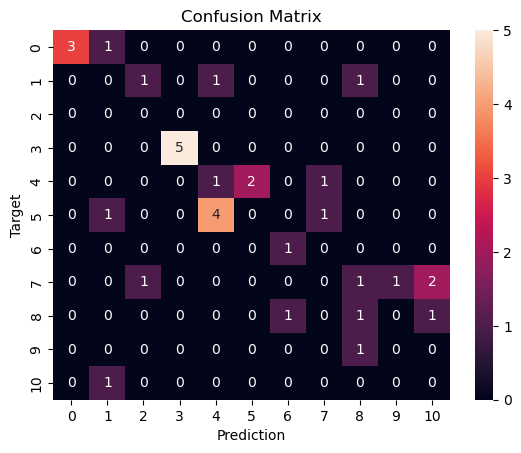

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=2)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
cf = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cf, annot=True)
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title('Confusion Matrix')

![9PCA_6_2](https://user-images.githubusercontent.com/7457301/224486228-89c7f97d-4877-4ba9-8e40-66e24bc59c65.png)

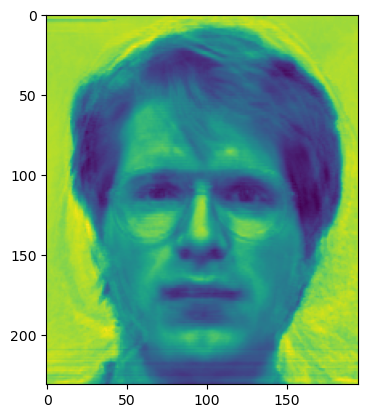

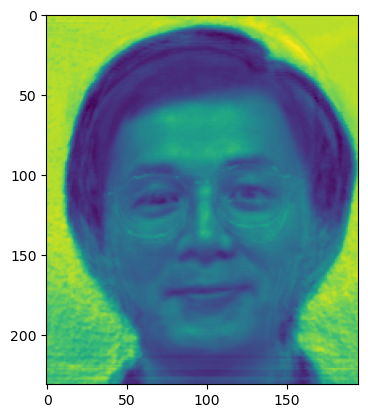

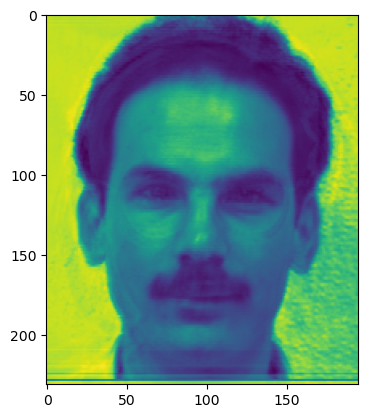

In [6]:
# Here are the recovered images, we can see PCA as a compression method:
X_recovered = pca.inverse_transform(X_pca)
for i in range (3):
    plt.imshow(X_recovered[i].reshape(231,195))
    plt.show()

![9PCA_7_0](https://user-images.githubusercontent.com/7457301/224486230-fc826c4b-e219-492f-85d5-f89c191b7d3d.png)
![9PCA_7_1](https://user-images.githubusercontent.com/7457301/224486231-b4526dd2-6b48-4881-8442-64edac06cd76.png)
![9PCA_7_2](https://user-images.githubusercontent.com/7457301/224486235-6ad62450-5c22-4183-98e9-92d968761268.png)

In [7]:
# if we run random forest on the restored dataset,
# the accuracy raises back to 39%
X_tilde=[]
for i in range (165):
    X_tilde.append(X_recovered[i])
X_tilde=np.array(X_tilde)
X_tilde.shape

(165, 45045)

Accuracy: 39.39%


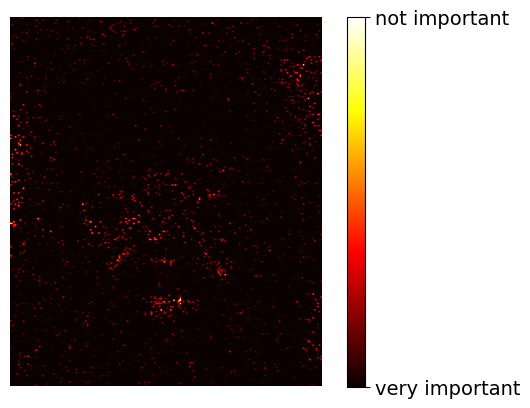

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_tilde, y, test_size=0.2, random_state=2)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

heatmap_image = rnd_clf.feature_importances_.reshape(231,195)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['very important', 'not important'], fontsize=14)
plt.axis("off")
plt.show()

# with pca, the algorithms look briefly overall the images, 
# with focus on the light and the complexion.

![9PCA_9_1](https://user-images.githubusercontent.com/7457301/224486237-7fb954df-4664-4c95-8873-2979ba25eb09.png)

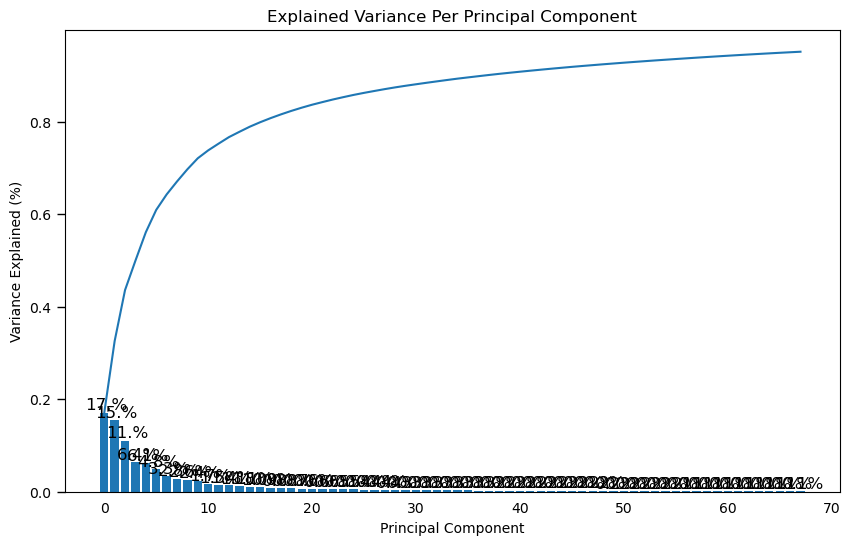

In [9]:
def plot_explained_variance(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(round(vals[i]*100,1))[:3])), (ind[i]+0.2, vals[i]), 
                    va="bottom", 
                    ha="center", 
                    fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=1, length=6)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
plot_explained_variance(pca)

![9PCA_10_0](https://user-images.githubusercontent.com/7457301/224486238-39da12a5-acfe-4c11-b0c0-f8a3db95875c.png)

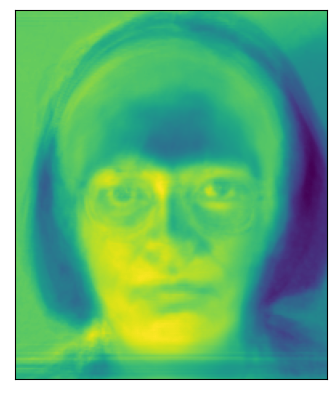

In [10]:
# here are some main components:
def plot_component(pca, comp):
    if comp <= len(pca.components_):
        mat_data = np.asmatrix(pca.components_[comp]).reshape(231,195)  #reshape images
        plt.imshow(mat_data); #plot the data
        plt.xticks([]) #removes numbered labels on x-axis
        plt.yticks([]) #removes numbered labels on y-axis   
plot_component(pca, 0)

![9PCA_11_0](https://user-images.githubusercontent.com/7457301/224486239-d2cf967d-9560-4cf6-b036-8784ab4e1ab4.png)

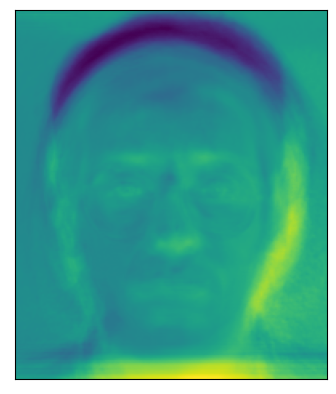

In [11]:
plot_component(pca, 1)

![9PCA_12_0](https://user-images.githubusercontent.com/7457301/224486242-76e71998-9c92-43f3-8617-95cbdfd65321.png)

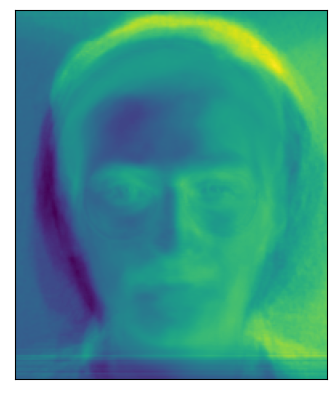

In [12]:
plot_component(pca, 2)

![9PCA_13_0](https://user-images.githubusercontent.com/7457301/224486243-5ea56e02-1f06-4309-8bd7-b2dab239cb99.png)